In [41]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import sklearn as sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [42]:
def fuzzyEvaluator(data):
    # Load your data and select relevant columns

    selected_columns = [
        'BIA-BIA_ICW',
        'BIA-BIA_TBW',
        'BIA-BIA_FFM',
        'BIA-BIA_BMR',
        'BIA-BIA_LST'
    ]

    # # Basic_Demos-Sex, Physical-Waist_Circumference appears twice at top of PCA iterations
    # selected_columns = [
    #     'BIA-BIA_ICW',
    #     'Physical-Weight',
    #     'FGC-FGC_SRR',
    #     'FGC-FGC_PU',
    #     'FGC-FGC_GSND',
    #     'SDS-SDS_Total_T',
    #     'Fitness_Endurance-Time_Mins',
    #     'BIA-BIA_FFMI',
    #     'Physical-Diastolic_BP',
    #     'FGC-FGC_TL_Zone',
    #     'Basic_Demos-Sex',
    #     'PAQ_C-PAQ_C_Total',
    #     'PAQ_A-PAQ_A_Total',
    #     'CGAS-CGAS_Score',
    #     'Fitness_Endurance-Time_Sec',
    #     'FGC-FGC_CU_Zone',
    #     'BIA-BIA_Activity_Level_num',
    #     'PreInt_EduHx-computerinternet_hoursday',
    #     'Physical-Waist_Circumference',
    # ]

    
    subset_df = data[selected_columns].copy()

    # Impute missing values and scale the data
    imputer = SimpleImputer(strategy='median')
    subset_df_imputed = imputer.fit_transform(subset_df)
    scaler = StandardScaler()
    subset_df_scaled = scaler.fit_transform(subset_df_imputed)

    # Transpose data for skfuzzy (expects features as rows)
    subset_df_scaled_T = subset_df_scaled.T

    # Perform fuzzy C-means clustering
    n_clusters = 4
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        subset_df_scaled_T, n_clusters, m=2, error=0.005, maxiter=1000, init=None, seed=42
    )

    # Assign each sample to the cluster with the highest membership probability
    fuzzy_clusters = np.argmax(u, axis=0)
    data['fuzzy_cluster'] = fuzzy_clusters

    # # View clustering results
    # print(train_df[['id', 'fuzzy_cluster'] + selected_columns].head(20))

    cluster_result = data[['id', 'fuzzy_cluster']]

    # Display the first few rows to verify
    print(cluster_result.head())
    return cluster_result

In [43]:
train_df = pd.read_csv('train.csv')
train_df = train_df.dropna(subset=['PCIAT-PCIAT_Total'])

# target_columns = [
#     'BIA-BIA_ICW',
#     'BIA-BIA_TBW',
#     'BIA-BIA_FFM',
#     'BIA-BIA_BMR',
#     'BIA-BIA_LST'
# ]

# target_columns = [
#     'BIA-BIA_ICW',
#     'Physical-Weight',
#     'FGC-FGC_SRR',
#     'FGC-FGC_PU',
#     'FGC-FGC_GSND',
#     'SDS-SDS_Total_T',
#     'Fitness_Endurance-Time_Mins',
#     'BIA-BIA_FFMI',
#     'Physical-Diastolic_BP',
#     'FGC-FGC_TL_Zone',
#     'Basic_Demos-Sex',
#     'PAQ_C-PAQ_C_Total',
#     'PAQ_A-PAQ_A_Total',
#     'CGAS-CGAS_Score',
#     'Fitness_Endurance-Time_Sec',
#     'FGC-FGC_CU_Zone',
#     'BIA-BIA_Activity_Level_num',
#     'PreInt_EduHx-computerinternet_hoursday',
#     'Physical-Waist_Circumference',
# ]

# train_df = train_df.dropna(subset=target_columns)

PCIAT_Values = train_df
cluster_result = fuzzyEvaluator(train_df)

         id  fuzzy_cluster
0  00008ff9              2
1  000fd460              2
2  00105258              0
3  00115b9f              0
5  001f3379              0


In [44]:
# PCIAT_Values = train_df['PCIAT-PCIAT_Total']


bins = [-1, 30, 49, 79, 100]
labels = [0, 1, 2, 3]

# Categorize and assign back to the original column
PCIAT_Values['PCIAT-PCIAT_Total'] = pd.cut(PCIAT_Values['PCIAT-PCIAT_Total'], bins=bins, labels=labels, include_lowest=True)
# print(PCIAT_Values['PCIAT-PCIAT_Total'])

# print(cluster_result.shape)
# print(PCIAT_Values.shape)

# create a new column match in cluster_result dataframe called 'match' if row in cluster_result['fuzzy_cluster'] == PCIAT_Values['PCIAT-PCIAT_Total']
cluster_result['match'] = np.where(cluster_result['fuzzy_cluster'] == PCIAT_Values['PCIAT-PCIAT_Total'], 1, 0)
# print(cluster_result['match'])



C:\Users\kevin\AppData\Local\Temp\ipykernel_83852\2256753086.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_result['match'] = np.where(cluster_result['fuzzy_cluster'] == PCIAT_Values['PCIAT-PCIAT_Total'], 1, 0)


In [45]:
print("number correct", cluster_result['match'].sum())
print("total valid samples", cluster_result.shape[0])
print("testing accuracy", cluster_result['match'].sum()/cluster_result.shape[0])

number correct 1086
total valid samples 2736
testing accuracy 0.3969298245614035


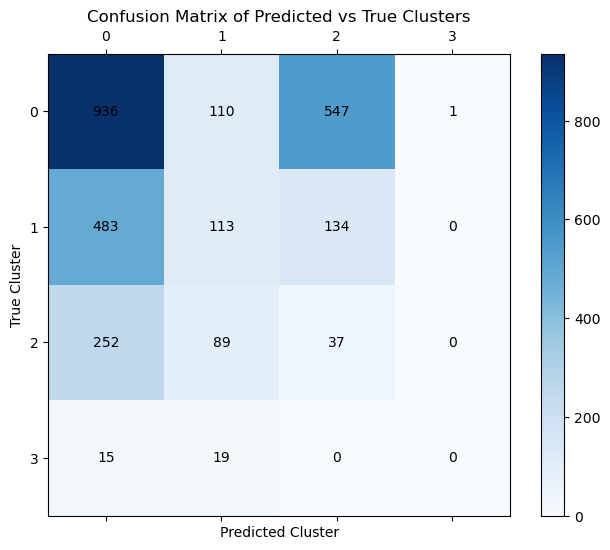

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
true_values = PCIAT_Values['PCIAT-PCIAT_Total'].astype(int)
predicted_values = cluster_result['fuzzy_cluster']
conf_matrix = confusion_matrix(true_values, predicted_values, labels=[0, 1, 2, 3])

# Plot the confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap="Blues")
fig.colorbar(cax)

# Add labels to the axes
ax.set_xlabel('Predicted Cluster')
ax.set_ylabel('True Cluster')
ax.set_title('Confusion Matrix of Predicted vs True Clusters')

# Add x and y ticks
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels([0, 1, 2, 3])
ax.set_yticklabels([0, 1, 2, 3])

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

plt.show()

In [47]:
test_df = pd.read_csv('test.csv')
fuzzyEvaluator(test_df)

         id  fuzzy_cluster
0  00008ff9              0
1  000fd460              0
2  00105258              3
3  00115b9f              3
4  0016bb22              3


,id,fuzzy_cluster
0,00008ff9,0
1,000fd460,0
2,00105258,3
3,00115b9f,3
4,0016bb22,3
5,001f3379,2
6,0038ba98,3
7,0068a485,3
8,0069fbed,3
9,0083e397,3
